In [1]:
import os
import sys
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import medchem as mc
import pickle
import pandas as pd
from helpers import get_scores, check_smarts_filters
from sascorer import calculateScore
opts = Draw.MolDrawOptions()
opts.legendFraction = 0.25
opts.legendFontSize = 20

### Set-up and Sampling

In [2]:
# Set up folders for sampling from checkpoints

output_folder = "../outputs/"
config_folder=  "../config/"
model_folder = "../models"
acquisition_function = "UCB"
kappa=1.0
n_samples = 3 # Number of times to sample from each checkpoint

# Load models for scoring and prediction

models = []
model_names = []
for file in [x for x  in os.listdir(model_folder) if "pkl" in x]:
    model_path = os.path.join(model_folder, file)
    with open(model_path, "rb") as f:
        models.append(pickle.load(f))
    model_names.append(file.split(".")[0])

print("Models found:")
for name in model_names:
    print(name)

Models found:
JNK1_PIC50


/home/cwoodley/.local/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator VarianceThreshold from version 1.5.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/cwoodley/.local/lib/python3.10/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.5.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [23]:
# Dictionary for scoring function
# Applies scoring functions identically to as if in .toml file
# Here we use the upper confidence bound for hlm to take into account uncertainty

scoring_dict = {
    "value_names" : ["JNK1_PIC50",
                     "MolWt", 
                    ],
    "scoring_params" : [("sigmoid", 8.0, 6.0, 0.5), 
                        ("reverse_sigmoid", 600,400,0.5), 
                    ],
    "weights" : [1.,0.6]
}

In [15]:
# Sample from checkpoint files

sampled_mols = pd.DataFrame()

for file in [x for x in os.listdir(model_folder) if "chkpt" in x and "checkpoint" in x]:
    checkpoint_file = os.path.join(model_folder,file)

    basename = file.split(".")[0]
    output_csv = os.path.join(output_folder, basename+".csv")
    output_log = os.path.join(output_folder, basename+".log")
    toml_file = os.path.join(config_folder, basename+".toml")
    sampling_toml = f"""# REINVENT4 TOML input example for sampling
    #


    run_type = "sampling"
    device = "cuda:0"  # set torch device e.g. "cpu"
    json_out_config = "./_sampling.json"  # write this TOML to JSON


    [parameters]

    ## LibInvent: find R-groups for the given scaffolds
    model_file = "{checkpoint_file}"
    smiles_file = "../config/scaffolds_pmx.smi"  # 1 scaffold per line with attachment points

    output_file = '{output_csv}'  # sampled SMILES and NLL in CSV format

    num_smiles = 2000  # number of SMILES to be sampled, 1 per input SMILES
    unique_molecules = false  # if true remove all duplicatesd canonicalize smiles
    randomize_smiles = false # if true shuffle atoms in SMILES randomly

    """

    with open(toml_file,"w") as f:
        f.writelines(sampling_toml)

    temp_sampled = pd.DataFrame()
    for i in range(n_samples):
        os.system(f"reinvent {toml_file} -l {output_log}")
        results = pd.read_csv(output_csv)
        os.remove(output_csv)
        os.remove("./_sampling.json")
        os.remove(output_log)
        temp_sampled = pd.concat([temp_sampled, results])
    sampled_mols = pd.concat([sampled_mols, temp_sampled])
sampled_mols = sampled_mols[["SMILES","Scaffold","R-groups"]]

# Sample from molecules generated while training

for file in [x for x in os.listdir(output_folder) if "staged_learning" in x]:

    learning_csv = pd.read_csv(os.path.join(output_folder, file))
    learning_csv.rename(columns={"Input_Scaffold":"Scaffold"}, inplace=True)
    learning_csv = learning_csv[["SMILES","Scaffold","R-groups"]]
    sampled_mols = pd.concat([sampled_mols, learning_csv], axis=0).reset_index(drop=True)

sampled_mols.drop_duplicates("SMILES", inplace=True)
sampled_mols.reset_index(drop=True, inplace=True)
sampled_mols = sampled_mols[["*" not in x for x in sampled_mols["SMILES"]]].reset_index(drop=True)

### Chemical space analysis of sampled molecules

Text(0.5, 1.0, 't-SNE Projection of Generated Compounds')

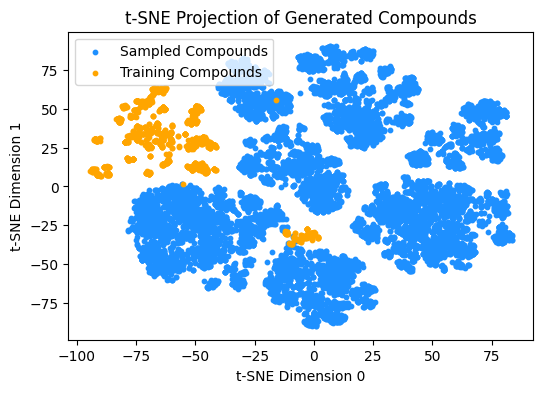

In [16]:
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)

training_df = pd.read_csv("../data/JNK1_processed.csv")
training_mols = [Chem.MolFromSmiles(x) for x in training_df["Smiles"]]
all_mols = training_mols + [Chem.MolFromSmiles(x) for x in sampled_mols["SMILES"]]
fp = np.array([AllChem.GetMorganFingerprintAsBitVect(x, 2, 2048) for x in all_mols])

sampled_tsne = tsne.fit_transform(fp)

fig, ax = plt.subplots(1,1,figsize=(6,4))

ax.scatter(sampled_tsne[len(training_mols):,0], sampled_tsne[len(training_mols):,1], label="Sampled Compounds", color="dodgerblue", s=10)
ax.scatter(sampled_tsne[:len(training_mols),0], sampled_tsne[:len(training_mols),1], label="Training Compounds", color="orange", s=10)
ax.legend(loc="upper left")
ax.set_ylabel("t-SNE Dimension 1")
ax.set_xlabel("t-SNE Dimension 0")
ax.set_title("t-SNE Projection of Generated Compounds")

### Scoring molecules by scoring function

In [24]:
from helpers import dundee_filter

# ## Apply molecular filters here

sampled_mols["ro_gen_design"] = sampled_mols["SMILES"].apply(mc.rules.basic_rules.rule_of_generative_design)

filter_dict = dundee_filter
filter_dict["acetal"] = "[#8]-[#6]-[#8]"

sampled_mols["struc_alerts"] = [check_smarts_filters(x, filter_dict)[0] for x in sampled_mols["SMILES"]]
sampled_mols["macrocycle"] = mc.functional.macrocycle_filter([Chem.MolFromSmiles(x) for x in sampled_mols["SMILES"]], max_cycle_size=8)

reject_mols = sampled_mols.loc[((sampled_mols["struc_alerts"] == False)|(sampled_mols["macrocycle"] == False))].reset_index(drop=True)  
reject_mols["dundee_matches"] = [check_smarts_filters(x)[1] for x in reject_mols["SMILES"]]
sampled_mols = sampled_mols.loc[((sampled_mols["struc_alerts"] == True)&(sampled_mols["macrocycle"] == True))].reset_index(drop=True)

# Apply models to get predictions

for model, name in zip(models, model_names):
    predictions, std = model.predict_from_smiles(sampled_mols.SMILES, uncert=True)
    af = model.evaluate_acquisition_functions(sampled_mols.SMILES, acquisition_function, kappa=kappa)

    model_eval = pd.DataFrame({name: predictions, 
              name+"_std": std, 
              acquisition_function+"_"+name:af})

    sampled_mols = pd.concat([sampled_mols, model_eval], axis=1)

# Calculate Physchem properties

sampled_mols["HBA"] = [Chem.rdMolDescriptors.CalcNumHBA(Chem.MolFromSmiles(x)) for x in sampled_mols["SMILES"]]
sampled_mols["HBD"] = [Chem.rdMolDescriptors.CalcNumHBD(Chem.MolFromSmiles(x)) for x in sampled_mols["SMILES"]]
sampled_mols["MolWt"] = [Chem.rdMolDescriptors.CalcExactMolWt(Chem.MolFromSmiles(x)) for x in sampled_mols["SMILES"]]
sampled_mols["TPSA"] = [Chem.rdMolDescriptors.CalcTPSA(Chem.MolFromSmiles(x)) for x in sampled_mols["SMILES"]]
sampled_mols["SA_score"] = [calculateScore(Chem.MolFromSmiles(x)) for x in sampled_mols["SMILES"]]

sampled_mols["Custom_score"] = get_scores(sampled_mols, scoring_dict)

# Save sampled molecules with scores

sampled_mols.to_csv(os.path.join(output_folder, "sampled_mols.csv"))
reject_mols.to_csv(os.path.join(output_folder, "reject_mols.csv"))

In [19]:
# Load in sampled csv if already sampled and scored

# sampled_mols = pd.read_csv(os.path.join(output_folder, "sampled_mols.csv"))

### Analysis and visualisation of sampled structures

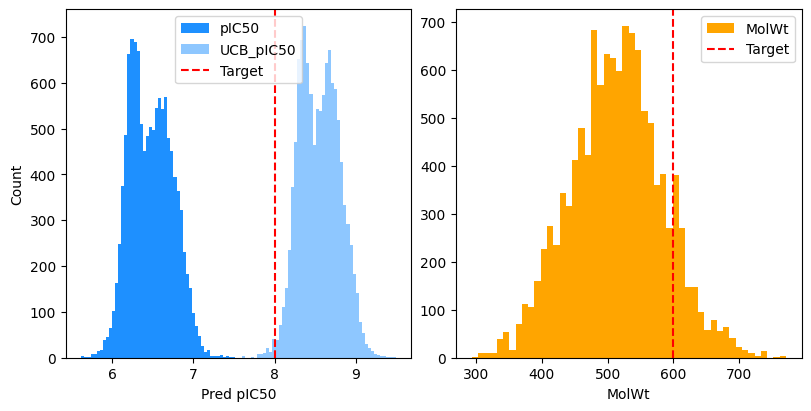

In [42]:
# Distributions of predicted properties

fig, axs = plt.subplots(1,2,figsize=(8,4), layout="constrained")
axs[0].hist(sampled_mols["JNK1_PIC50"], color="dodgerblue", label = "pIC50", bins=50)
axs[0].hist(sampled_mols["UCB_JNK1_PIC50"], color="dodgerblue", label = "UCB_pIC50", alpha=0.5, bins=50)
axs[0].axvline(8.0, color="red", linestyle="--", label="Target")
axs[0].legend()
axs[0].set_ylabel("Count")
axs[0].set_xlabel("Pred pIC50")

axs[1].hist(sampled_mols["MolWt"], color="orange", label = "MolWt", bins=50)
axs[1].axvline(600.0, color="red", linestyle="--", label="Target")
axs[1].legend()
axs[1].set_xlabel("MolWt")

plt.show()

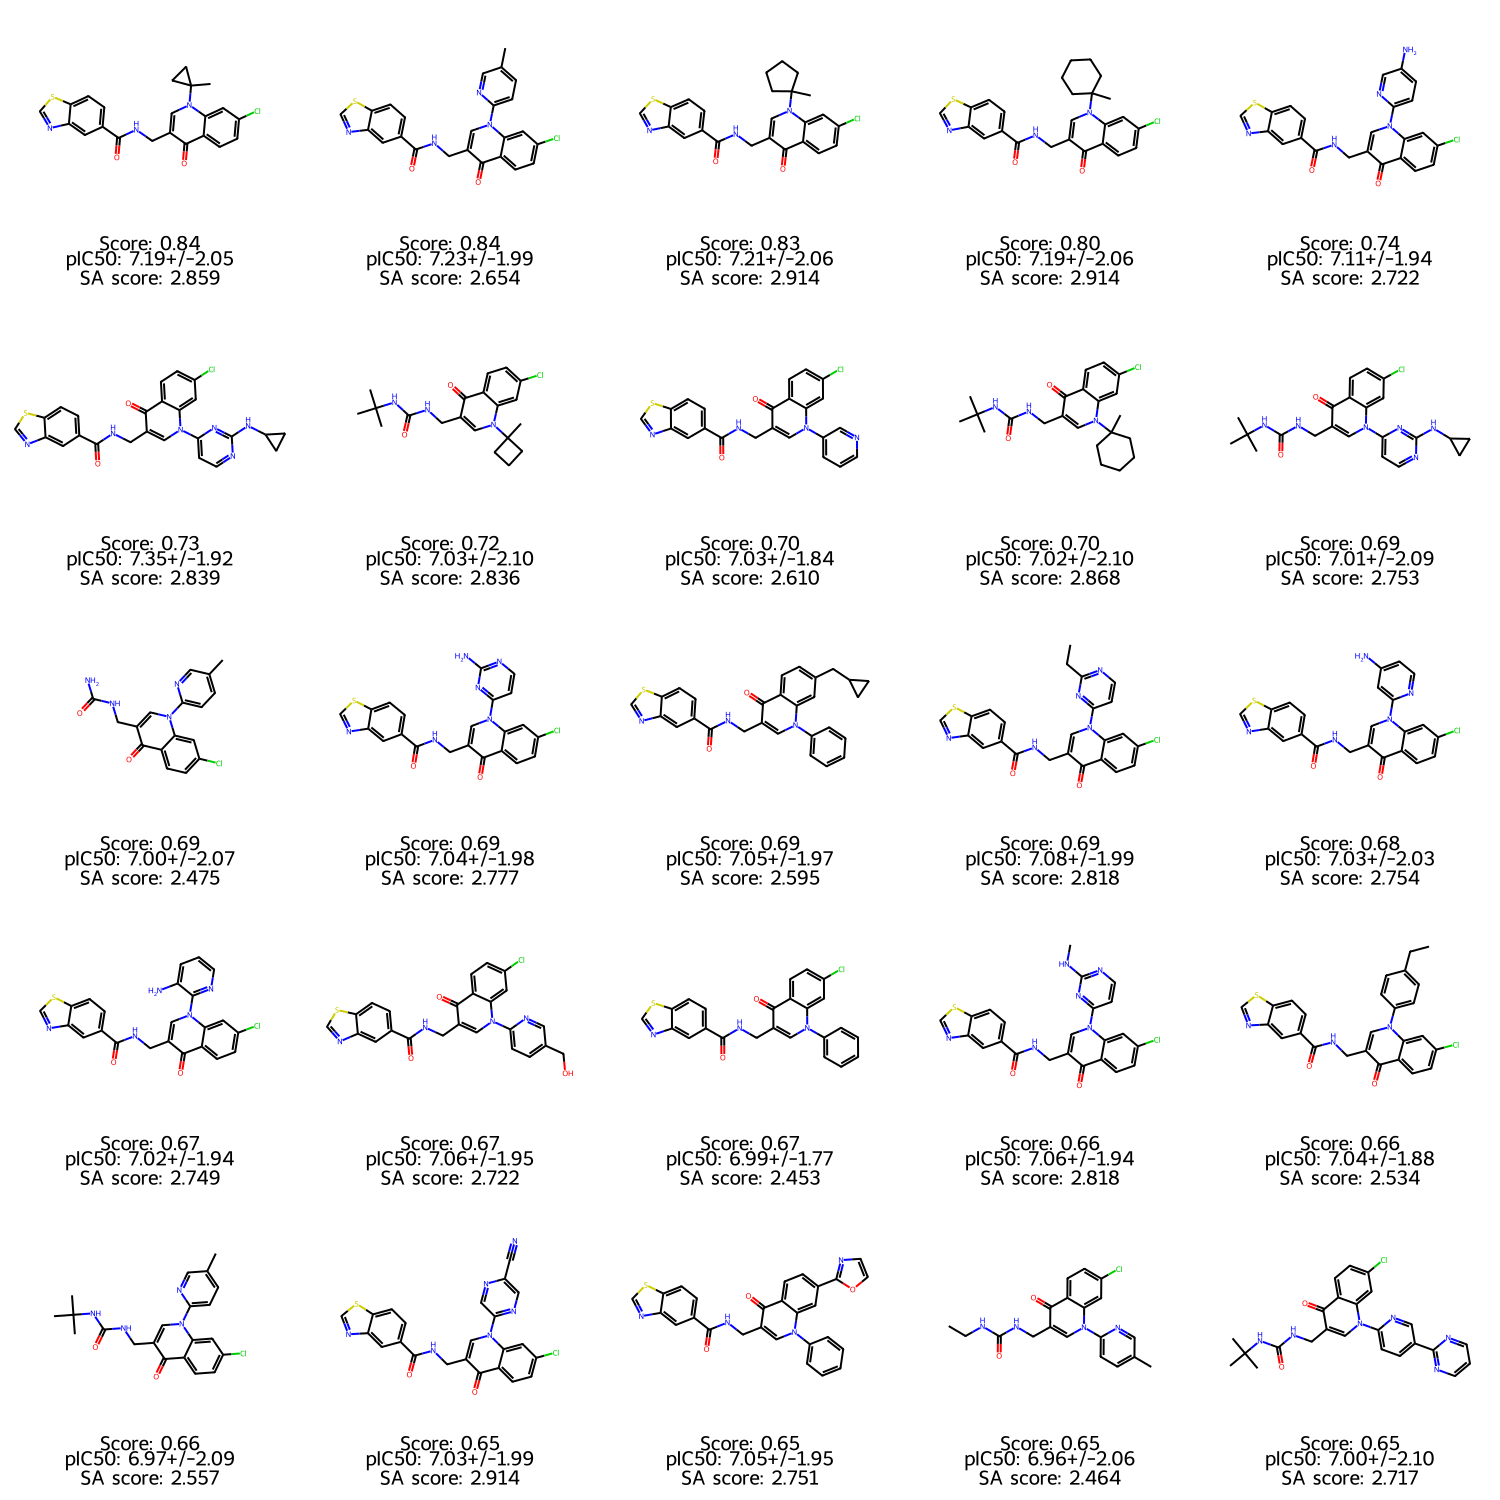

In [27]:
# View top 50 molecules by custom scoring function - scoring function enables MPO

MPO_score = sampled_mols.sort_values("Custom_score", ascending=False).reset_index(drop=True).iloc[:25]
MPO_mols = [Chem.MolFromSmiles(x) for x in MPO_score.SMILES]

legends = []
for i in range(len(MPO_mols)):
    legends.append("Score: {:.2f}\npIC50: {:.2f}+/-{:.2f}\nSA score: {:.3f}".format(
        MPO_score["Custom_score"].to_numpy()[i],
        MPO_score["JNK1_PIC50"].to_numpy()[i],MPO_score["JNK1_PIC50_std"].to_numpy()[i],
        MPO_score["SA_score"][i]
    ))

Draw.MolsToGridImage(MPO_mols, useSVG=False, legends=legends, drawOptions=opts, molsPerRow=5, subImgSize=(300,300))



/home/cwoodley/.local/lib/python3.10/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


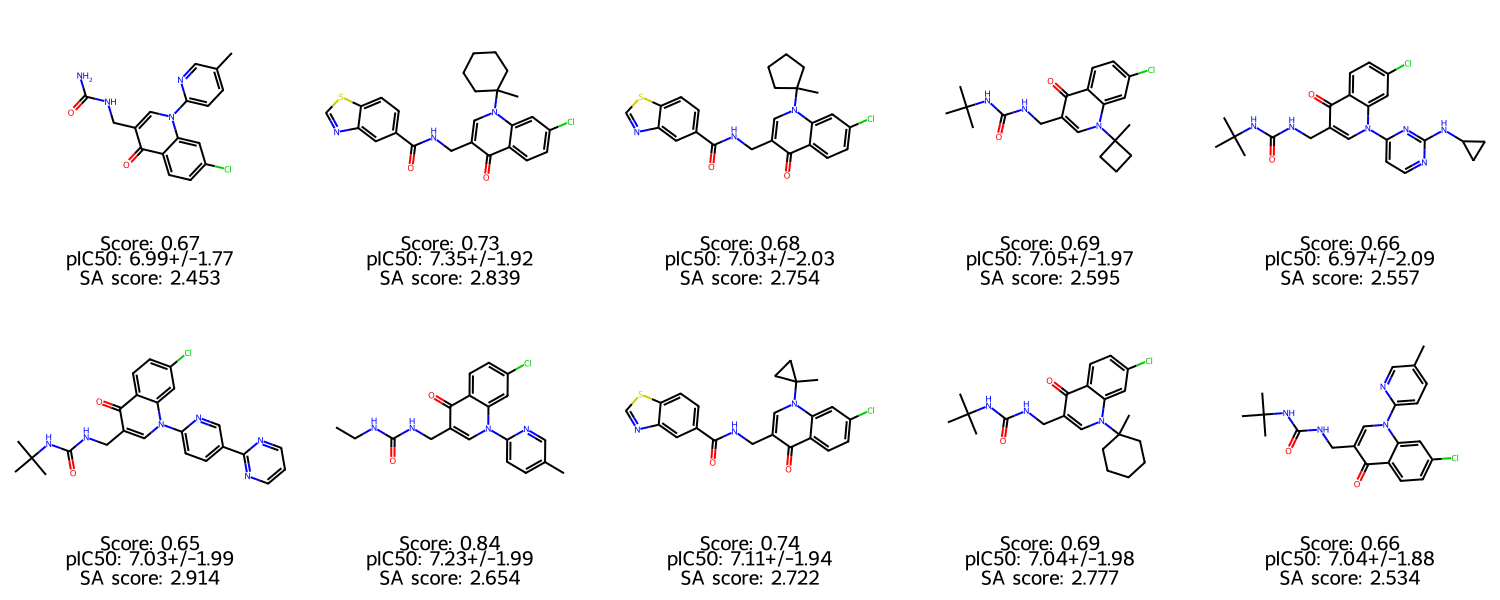

In [28]:
# Selection by GPO method

# Cutoff for custom score to select from balanced subset
batch_df = sampled_mols.loc[sampled_mols["Custom_score"] > 0.65].reset_index(drop=True)

# Select batch with gPO method - maximise probability of best compound being within the batch
selection, probs = models[0].batch_selection(batch_df.SMILES, method="gpo")

selected_df = batch_df.loc[selection].reset_index(drop=True)

batch_mols = [Chem.MolFromSmiles(x) for x in selected_df.SMILES]

legends = []
for i in range(len(batch_mols)):
    legends.append("Score: {:.2f}\npIC50: {:.2f}+/-{:.2f}\nSA score: {:.3f}".format(
        batch_df["Custom_score"].to_numpy()[i],
        batch_df["JNK1_PIC50"].to_numpy()[i],batch_df["JNK1_PIC50_std"].to_numpy()[i],
        batch_df["SA_score"][i]
    ))

# UCB_score.to_csv("../outputs/20240920_top_25.csv")

Draw.MolsToGridImage(batch_mols, useSVG=False, legends=legends, drawOptions=opts, molsPerRow=5, subImgSize=(300,300))

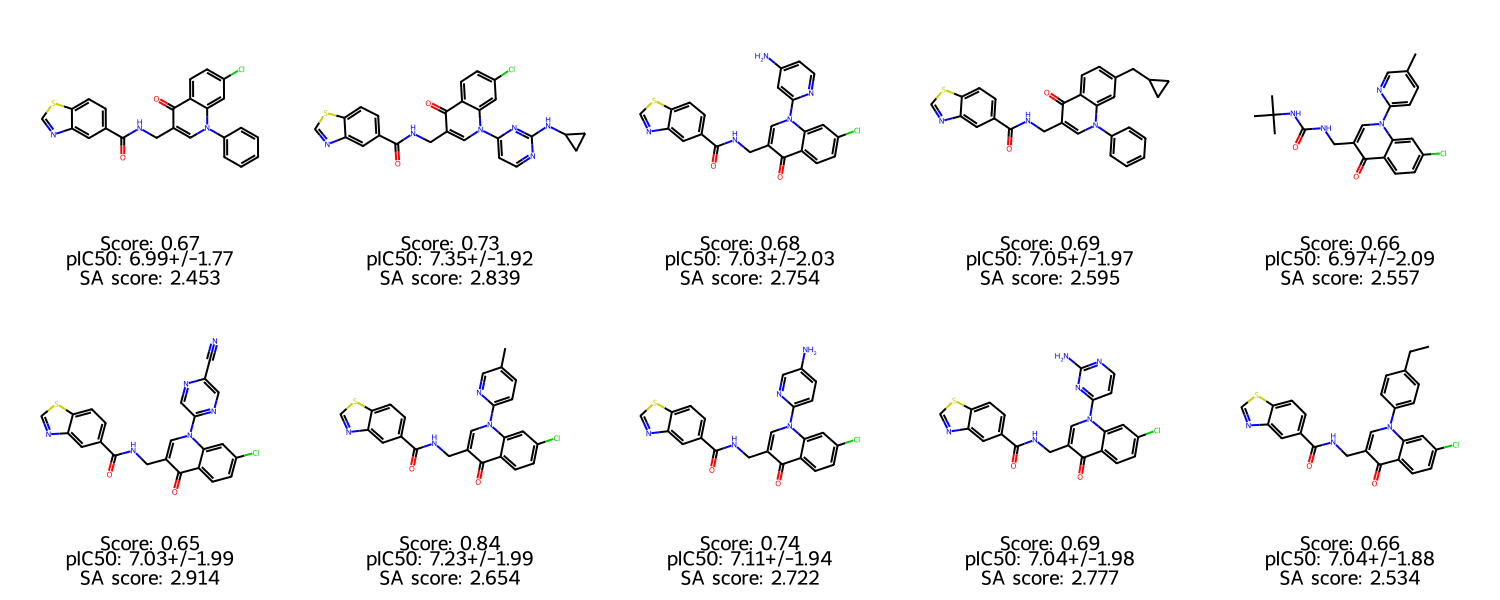

In [44]:
# Selection by Greedy batch selection - maximise entropy in joint covariance matrix

# Cutoff for custom score to select from balanced subset
batch_df = sampled_mols.loc[sampled_mols["Custom_score"] > 0.65].reset_index(drop=True)

# Select batch with gPO method - maximise probability of best compound being within the batch
selection = models[0].batch_selection(batch_df.SMILES, method="greedy")

selected_df = batch_df.loc[selection].reset_index(drop=True)

batch_mols = [Chem.MolFromSmiles(x) for x in selected_df.SMILES]

legends = []
for i in range(len(batch_mols)):
    legends.append("Score: {:.2f}\npIC50: {:.2f}+/-{:.2f}\nSA score: {:.3f}".format(
        batch_df["Custom_score"].to_numpy()[i],
        batch_df["JNK1_PIC50"].to_numpy()[i],batch_df["JNK1_PIC50_std"].to_numpy()[i],
        batch_df["SA_score"][i]
    ))

# UCB_score.to_csv("../outputs/20240920_top_25.csv")

Draw.MolsToGridImage(batch_mols, useSVG=False, legends=legends, drawOptions=opts, molsPerRow=5, subImgSize=(300,300))

/home/cwoodley/.local/lib/python3.10/site-packages/scipy/stats/_multivariate.py:757: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


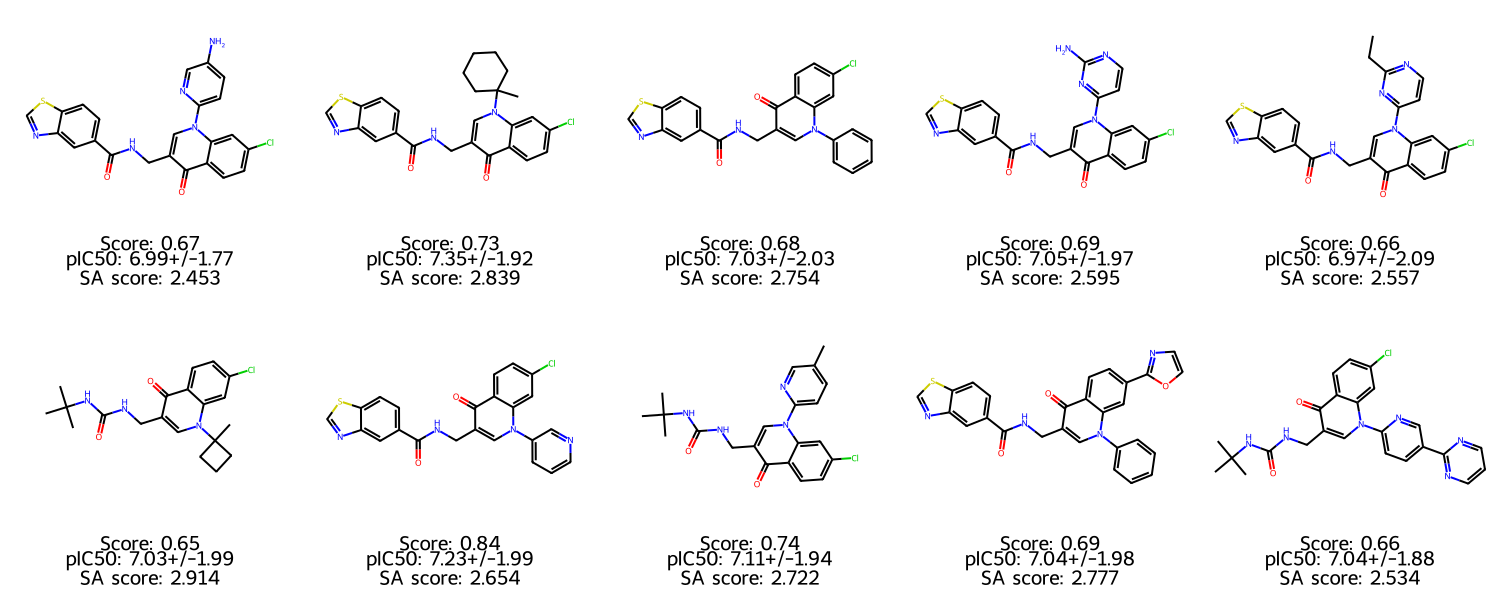

In [46]:
# Selection by parallel Thompson sampling

# Cutoff for custom score to select from balanced subset
batch_df = sampled_mols.loc[sampled_mols["Custom_score"] > 0.65].reset_index(drop=True)

# Select batch with gPO method - maximise probability of best compound being within the batch
selection = models[0].batch_selection(batch_df.SMILES, method="ts")

selected_df = batch_df.loc[selection].reset_index(drop=True)

batch_mols = [Chem.MolFromSmiles(x) for x in selected_df.SMILES]

legends = []
for i in range(len(batch_mols)):
    legends.append("Score: {:.2f}\npIC50: {:.2f}+/-{:.2f}\nSA score: {:.3f}".format(
        batch_df["Custom_score"].to_numpy()[i],
        batch_df["JNK1_PIC50"].to_numpy()[i],batch_df["JNK1_PIC50_std"].to_numpy()[i],
        batch_df["SA_score"][i]
    ))

# UCB_score.to_csv("../outputs/20240920_top_25.csv")

Draw.MolsToGridImage(batch_mols, useSVG=False, legends=legends, drawOptions=opts, molsPerRow=5, subImgSize=(300,300))